In [1]:
import os, sys
import numpy as np
from os.path import dirname
from cmdstanpy import CmdStanModel
from pandas import DataFrame, concat
from scipy.stats import norm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = '2pl'
seed = 125

## Simulation parameters.
n_subj  = 600
n_item  = 30
n_split = 3

## Sampling parameters.
iter_warmup   = 2000
iter_sampling = 1000
chains = 4
thin = 1
parallel_chains = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(seed)

def inv_logit(x):
    return 1 / (1 + np.exp(-x))
    
## Define item order.
ix = np.arange(n_item).reshape(n_split, n_item // n_split, order='F')
K = np.zeros((n_subj, n_item // n_split), dtype=int)
for i in range(n_subj): 
    ix = np.apply_along_axis(np.random.permutation, 0, ix)
    K[i] = ix[0]
    
## Define metadata.
K = K.flatten()
J = np.repeat(np.arange(n_subj), n_item // n_split)
N = J.size

## Generate subject abilities.
theta = np.random.normal(0, 1, n_subj)

## Iteratively sample item parameters.
bins = norm.ppf(np.linspace(0.005,0.995,10))
cov = [[1.50,0.00],[0.00,0.25]]

while True:
    beta, alpha = np.random.multivariate_normal(np.zeros(2), cov, n_item).T
    counts = np.bincount(np.digitize(beta, bins), minlength=bins.size + 1)[1:-1]
    if counts.min() >= 3: break
    break
        
## Sort parameters.
alpha = np.exp(alpha[np.argsort(beta)])
beta  = beta[np.argsort(beta)]

## Generate data.
mu = inv_logit(alpha[K] * (theta[J] - beta[K]))
Y = np.random.binomial(1, mu).astype(int)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble data.
dd = dict(N=N, J=J+1, K=K+1, Y=Y)

## Load StanModel
StanModel = CmdStanModel(stan_file=os.path.join('stan_models',f'{stan_model}.stan'))

## Fit Stan model.
StanFit = StanModel.sample(data=dd, chains=chains, iter_warmup=iter_warmup, iter_sampling=iter_sampling, 
                           thin=thin, parallel_chains=parallel_chains, seed=0, show_progress='notebook')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/szoro/Desktop/projects/mars/02_Design/stan_models/2pl


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'rho = 0.811')

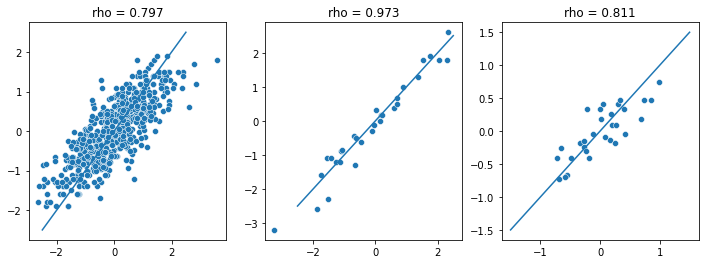

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Extract parameters.
summary = StanFit.summary()
theta_hat = summary.T.filter(regex='theta').T['50%'].values
beta_hat  = summary.T.filter(regex='beta').T['50%'].values
alpha_hat = summary.T.filter(regex='alpha').T['50%'].values

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

rho, _ = spearmanr(theta, theta_hat)
sns.scatterplot(x=theta, y=theta_hat, ax=axes[0])
axes[0].plot([-2.5,2.5],[-2.5,2.5])
axes[0].set_title(f'rho = %0.3f' %rho)

rho, _ = spearmanr(beta, beta_hat)
sns.scatterplot(x=beta, y=beta_hat, ax=axes[1])
axes[1].plot([-2.5,2.5],[-2.5,2.5])
axes[1].set_title(f'rho = %0.3f' %rho)

rho, _ = spearmanr(np.log(alpha), np.log(alpha_hat))
sns.scatterplot(x=np.log(alpha), y=np.log(alpha_hat), ax=axes[2])
axes[2].plot([-1.5,1.5],[-1.5,1.5])
axes[2].set_title(f'rho = %0.3f' %rho)

## normal

[19, 22, 15, 23, 12, 9, 24, 2, 18]


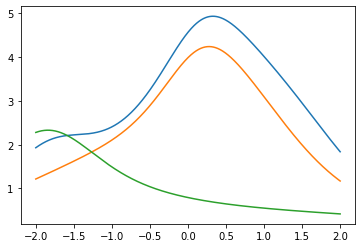

In [3]:
def info_2pl(theta, beta, alpha):
    p = inv_logit(alpha * (theta - beta))
    return alpha**2 * p * (1-p)

x = np.linspace(-2,2,1001)
info_true = np.zeros((n_item, x.size))
info_pred = np.zeros((n_item, x.size))
for i in range(n_item): 
    info_true[i] = info_2pl(x, beta[i], alpha[i])
    info_pred[i] = info_2pl(x, beta_hat[i], alpha_hat[i])
    
template = norm(0,1).pdf(x)

ground = [np.argmax(info_true @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), ground)
    tif = (info_true[ground].sum(axis=0) + info_true[ix]) @ template
    ground.append(ix[np.argmax(tif)])
    
chosen = [np.argmax(info_pred @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), chosen)
    tif = (info_pred[chosen].sum(axis=0) + info_pred[ix]) @ template
    chosen.append(ix[np.argmax(tif)])
    
worst = [np.argmin(info_pred @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), worst)
    tif = (info_pred[chosen].sum(axis=0) + info_pred[ix]) @ template
    worst.append(ix[np.argmin(tif)])
    
plt.plot(x, info_true[ground].sum(axis=0))
plt.plot(x, info_true[chosen].sum(axis=0))
plt.plot(x, info_true[worst].sum(axis=0))
print(chosen)

## uniform

[19, 22, 23, 15, 12, 24, 9, 2, 28]


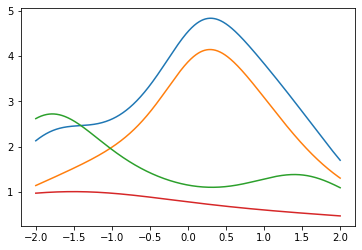

In [13]:
def info_2pl(theta, beta, alpha):
    p = inv_logit(alpha * (theta - beta))
    return alpha**2 * p * (1-p)

x = np.linspace(-2,2,1001)
info_true = np.zeros((n_item, x.size))
info_pred = np.zeros((n_item, x.size))
for i in range(n_item): 
    info_true[i] = info_2pl(x, beta[i], alpha[i])
    info_pred[i] = info_2pl(x, beta_hat[i], alpha_hat[i])
    
template = np.ones_like(x)

ground = [np.argmax(info_true @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), ground)
    tif = (info_true[ground].sum(axis=0) + info_true[ix]) @ template
    ground.append(ix[np.argmax(tif)])
    
chosen = [np.argmax(info_pred @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), chosen)
    tif = (info_pred[chosen].sum(axis=0) + info_pred[ix]) @ template
    chosen.append(ix[np.argmax(tif)])
    
worst = [np.argmin(info_pred @ template)]
for _ in range(1,9):
    
    ix = np.setdiff1d(np.arange(30), worst)
    tif = (info_pred[chosen].sum(axis=0) + info_pred[ix]) @ template
    worst.append(ix[np.argmin(tif)])
    
random = np.random.choice(np.arange(n_item), 9)
    
plt.plot(x, info_true[ground].sum(axis=0))
plt.plot(x, info_true[chosen].sum(axis=0))
plt.plot(x, info_true[random].sum(axis=0))
plt.plot(x, info_true[worst].sum(axis=0))
print(chosen)

In [16]:
J = np.repeat(np.arange(n_subj), len(chosen))
K = np.tile(chosen, n_subj)
mu = inv_logit(alpha[K] * (theta[J] - beta[K]))
Y = np.random.binomial(1,mu)
score = Y.reshape(n_subj, len(chosen)).sum(axis=1)

spearmanr(norm.cdf(theta), score)

SpearmanrResult(correlation=0.857630068324962, pvalue=7.425456255188207e-175)